In [4]:
import ccxt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
import torch
from torch_geometric.data import Data
from torch import nn, optim
import warnings
warnings.filterwarnings("ignore")


In [5]:
EXCHANGES = ['kucoin', 'gateio', 'huobi', 'bitget', 'mexc']
CURRENCY_PAIRS = ['BTC/USDT', 'ETH/USDT', 'SOL/USDT', 'XRP/USDT', 'LTC/USDT', 'ADA/USDT']


In [8]:
exchange_objs = {}
for ex in EXCHANGES:
    try:
        exchange_class = getattr(ccxt, ex)
        exchange = exchange_class()
        exchange.load_markets()
        exchange_objs[ex] = exchange
    except Exception as e:
        print(f"Failed to load {ex}: {e}")


In [9]:
import time

def fetch_ohlcv(exchange, symbol):
    try:
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe='1h', limit=24)
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)
        return df
    except Exception as e:
        return None

data_dict = {}

for ex in tqdm(exchange_objs):
    print(f"\nFetching data from {ex}...")
    for pair in CURRENCY_PAIRS:
        df = fetch_ohlcv(exchange_objs[ex], pair)
        if df is not None:
            df['normalized_close'] = df['close'] / df['close'].iloc[0]
            data_dict[(ex, pair)] = df
            print(f" {ex}_{pair} - OK")
        else:
            print(f" {ex}_{pair} - Not Found")
        time.sleep(1.5)  # Rate limit


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]


Fetching data from kucoin...
 kucoin_BTC/USDT - OK
 kucoin_ETH/USDT - OK
 kucoin_SOL/USDT - OK
 kucoin_XRP/USDT - OK
 kucoin_LTC/USDT - OK
 kucoin_ADA/USDT - OK


 20%|████████████████▊                                                                   | 1/5 [00:10<00:40, 10.02s/it]


Fetching data from gateio...
 gateio_BTC/USDT - OK
 gateio_ETH/USDT - OK
 gateio_SOL/USDT - OK
 gateio_XRP/USDT - OK
 gateio_LTC/USDT - OK
 gateio_ADA/USDT - OK


 40%|█████████████████████████████████▌                                                  | 2/5 [00:19<00:29,  9.97s/it]


Fetching data from huobi...
 huobi_BTC/USDT - OK
 huobi_ETH/USDT - OK
 huobi_SOL/USDT - OK
 huobi_XRP/USDT - OK
 huobi_LTC/USDT - OK
 huobi_ADA/USDT - OK


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [00:29<00:19,  9.87s/it]


Fetching data from bitget...
 bitget_BTC/USDT - OK
 bitget_ETH/USDT - OK
 bitget_SOL/USDT - OK
 bitget_XRP/USDT - OK
 bitget_LTC/USDT - OK
 bitget_ADA/USDT - OK


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [00:39<00:09,  9.94s/it]


Fetching data from mexc...
 mexc_BTC/USDT - OK
 mexc_ETH/USDT - OK
 mexc_SOL/USDT - OK
 mexc_XRP/USDT - OK
 mexc_LTC/USDT - OK
 mexc_ADA/USDT - OK


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:50<00:00, 10.08s/it]


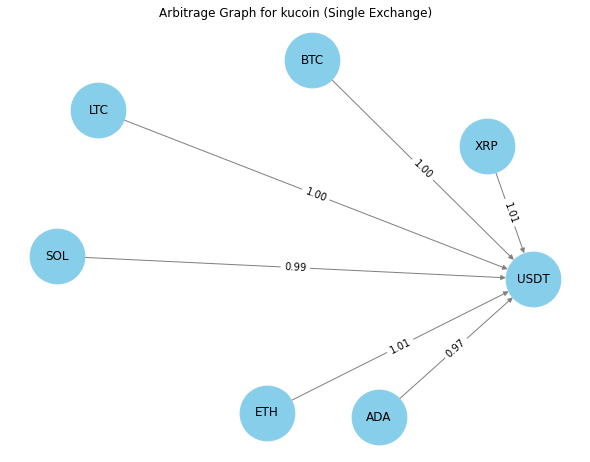

In [10]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt



selected_exchange = 'kucoin'


G = nx.DiGraph()


for pair in CURRENCY_PAIRS:
    key = (selected_exchange, pair)
    if key in data_dict:
        df = data_dict[key]
        
        latest_price = df['normalized_close'].iloc[-1]
        
        
        base, quote = pair.split('/')
        
        
        if not G.has_node(base):
            G.add_node(base)
        if not G.has_node(quote):
            G.add_node(quote)
            
        
        weight = -np.log(latest_price)
        G.add_edge(base, quote, weight=weight)


plt.figure(figsize=(8,6))

pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=12, edge_color='gray')


edge_labels = {(u, v): f"{np.exp(d['weight']):.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.title(f"Arbitrage Graph for {selected_exchange} (Single Exchange)")
plt.show()


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv



node_list = list(G.nodes())


node_features = torch.tensor([[1.0] for _ in node_list], dtype=torch.float)


edges = list(G.edges())
edge_index = torch.tensor([[node_list.index(u), node_list.index(v)] for u, v in edges], dtype=torch.long).t().contiguous()


data = Data(x=node_features, edge_index=edge_index)

print("Graph Data Object:", data)


class ArbitrageGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ArbitrageGNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        
        x = self.conv2(x, edge_index)
        return x


model = ArbitrageGNN(in_channels=1, hidden_channels=16, out_channels=1)


optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()


target = torch.ones_like(node_features)


epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)  
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

print("Training Completed!")


Graph Data Object: Data(x=[7, 1], edge_index=[2, 6])
Epoch 0: Loss = 2.2923
Epoch 10: Loss = 0.4179
Epoch 20: Loss = 0.1269
Epoch 30: Loss = 0.1524
Epoch 40: Loss = 0.1000
Epoch 50: Loss = 0.1001
Epoch 60: Loss = 0.0883
Epoch 70: Loss = 0.0830
Epoch 80: Loss = 0.0765
Epoch 90: Loss = 0.0709
Training Completed!


In [12]:

model.eval()
with torch.no_grad():
    output = model(data) 
    arbitrage_scores = output.squeeze().numpy()  


print("Arbitrage Scores for each node:")
for node, score in zip(node_list, arbitrage_scores):
    print(f"{node}: {score:.2f}")


threshold = 1.0


flagged_nodes = [node for node, score in zip(node_list, arbitrage_scores) if score > threshold]

print("\nFlagged Nodes (Potential Arbitrage Opportunities):")
if flagged_nodes:
    for node in flagged_nodes:
        print(f"-> {node}")
else:
    print("No arbitrage opportunities detected based on the current threshold.")


cycles = list(nx.simple_cycles(G))
profitable_cycles = []
for cycle in cycles:
    
    total_weight = sum(G[u][v]['weight'] for u, v in zip(cycle, cycle[1:] + [cycle[0]]))
  
    if total_weight < 0:
        profit_factor = np.exp(-total_weight)
        profitable_cycles.append((cycle, profit_factor))

print("\nProfitable Arbitrage Cycles (Detected via Bellman-Ford logic):")
if profitable_cycles:
    for cycle, profit in profitable_cycles:
        print("Cycle:", " -> ".join(cycle), f"| Profit Factor: {profit:.2f}")
else:
    print("No profitable cycles detected in the current graph.")


Arbitrage Scores for each node:
BTC: 0.81
USDT: 1.48
ETH: 0.81
SOL: 0.81
XRP: 0.81
LTC: 0.81
ADA: 0.81

Flagged Nodes (Potential Arbitrage Opportunities):
-> USDT

Profitable Arbitrage Cycles (Detected via Bellman-Ford logic):
No profitable cycles detected in the current graph.


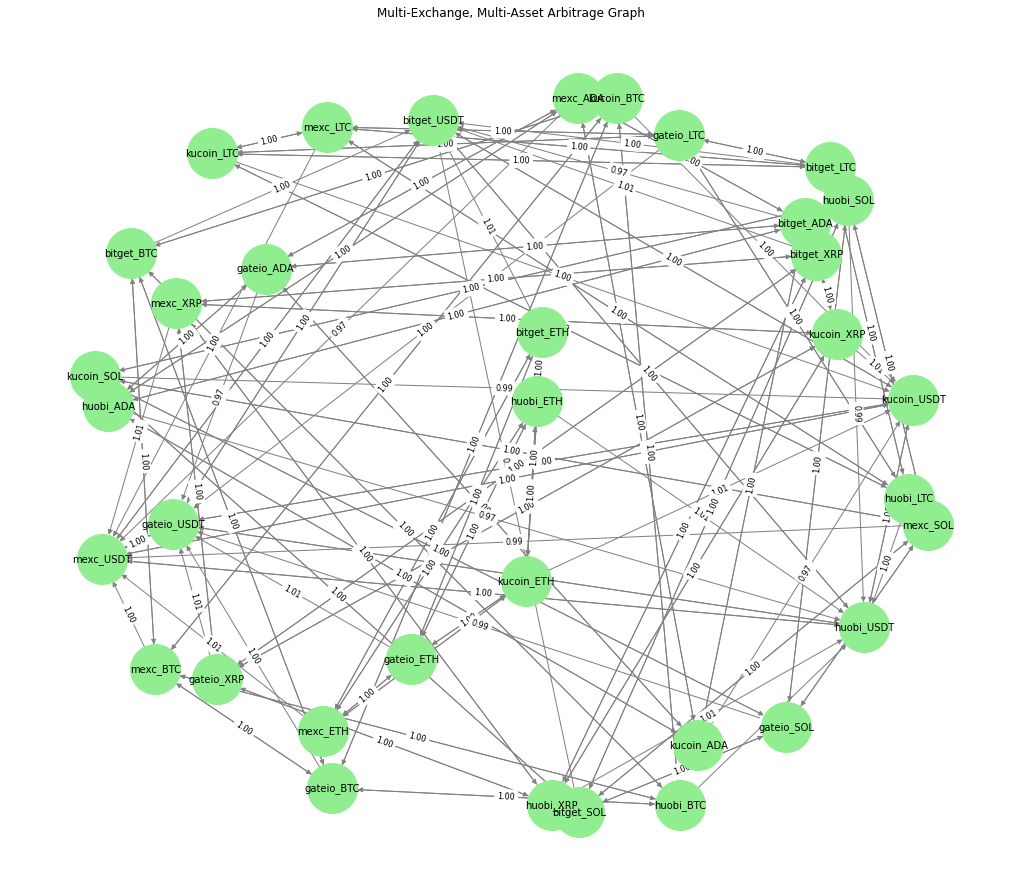

In [16]:


import numpy as np
import networkx as nx
import matplotlib.pyplot as plt


G_multi = nx.DiGraph()


node_prices = {}


for (ex, pair), df in data_dict.items():
    if df is not None and not df.empty:
        base, quote = pair.split('/')
        node_base = f"{ex}_{base}"
        node_quote = f"{ex}_{quote}"
        
        
        price = df['normalized_close'].iloc[-1]
        
       
        node_prices[node_base] = price
        node_prices[node_quote] = df['normalized_close'].iloc[-1]  
        
     
        G_multi.add_node(node_base)
        G_multi.add_node(node_quote)
        
     
        weight = -np.log(price)
        G_multi.add_edge(node_base, node_quote, weight=weight)



currency_nodes = {}
for node in G_multi.nodes():
    
    parts = node.split('_')
    if len(parts) == 2:
        ex, curr = parts
        currency_nodes.setdefault(curr, []).append(node)


for curr, nodes in currency_nodes.items():
    if len(nodes) > 1:
        for i in range(len(nodes)):
            for j in range(i + 1, len(nodes)):
                node1 = nodes[i]
                node2 = nodes[j]
                if node1 in node_prices and node2 in node_prices:
                    price1 = node_prices[node1]
                    price2 = node_prices[node2]
                    if price1 > 0 and price2 > 0:
                        
                        weight1to2 = np.log(price1 / price2)
                        
                        weight2to1 = np.log(price2 / price1)
                        G_multi.add_edge(node1, node2, weight=weight1to2)
                        G_multi.add_edge(node2, node1, weight=weight2to1)


plt.figure(figsize=(14, 12))
pos = nx.spring_layout(G_multi, seed=42)
nx.draw(G_multi, pos, with_labels=True, node_size=2500, node_color='lightgreen', font_size=10, edge_color='gray')
edge_labels_multi = {(u, v): f"{np.exp(d['weight']):.2f}" for u, v, d in G_multi.edges(data=True)}
nx.draw_networkx_edge_labels(G_multi, pos, edge_labels=edge_labels_multi, font_size=8)
plt.title("Multi-Exchange, Multi-Asset Arbitrage Graph")
plt.show()


In [17]:
import time


def detect_profitable_cycles(G):
    
    
    cycles = list(nx.simple_cycles(G))
    profitable_cycles = []
    for cycle in cycles:
        if len(cycle) > 1:
            
            cycle_edges = list(zip(cycle, cycle[1:] + [cycle[0]]))
            total_weight = sum(G[u][v]['weight'] for u, v in cycle_edges)
            
            if total_weight < 0:
                profit_factor = np.exp(-total_weight)  
                profitable_cycles.append((cycle, profit_factor))
    return profitable_cycles


start_bf = time.time()
profitable_cycles = detect_profitable_cycles(G_multi)
bf_time = time.time() - start_bf

print("Bellman-Ford Benchmark (Cycle Detection on Multi-Exchange Graph):")
print(f"Detected {len(profitable_cycles)} profitable cycles in {bf_time:.4f} seconds")
for cycle, profit in profitable_cycles:
    print("Cycle:", " -> ".join(cycle), f"| Profit Factor: {profit:.2f}")




node_list_multi = list(G_multi.nodes())
node_features_multi = torch.tensor([[1.0] for _ in node_list_multi], dtype=torch.float)
edges_multi = list(G_multi.edges())
edge_index_multi = torch.tensor([[node_list_multi.index(u), node_list_multi.index(v)] 
                                   for u, v in edges_multi], dtype=torch.long).t().contiguous()
data_multi = Data(x=node_features_multi, edge_index=edge_index_multi)


model.eval()
with torch.no_grad():
    start_gnn = time.time()
    output_multi = model(data_multi)
    end_gnn = time.time()
gnn_inference_time = end_gnn - start_gnn


gnn_scores_multi = output_multi.squeeze().numpy()
print("\nGNN Arbitrage Scores for Multi-Exchange Graph:")
for node, score in zip(node_list_multi, gnn_scores_multi):
    print(f"{node}: {score:.2f}")

print(f"\nGNN Inference Time on Multi-Exchange Graph: {gnn_inference_time:.4f} seconds")


print("\n--- Performance Metrics Summary ---")
print(f"Bellman-Ford Cycle Detection: {len(profitable_cycles)} cycles, {bf_time:.4f} seconds")
print(f"GNN Inference: {len(gnn_scores_multi)} nodes scored, {gnn_inference_time:.4f} seconds")


Bellman-Ford Benchmark (Cycle Detection on Multi-Exchange Graph):
Detected 308 profitable cycles in 0.0320 seconds
Cycle: gateio_ADA -> mexc_ADA -> bitget_ADA -> huobi_ADA | Profit Factor: 1.00
Cycle: gateio_ADA -> mexc_ADA -> huobi_ADA -> bitget_ADA | Profit Factor: 1.00
Cycle: gateio_ADA -> mexc_ADA -> huobi_ADA -> bitget_ADA -> kucoin_ADA | Profit Factor: 1.00
Cycle: gateio_ADA -> mexc_ADA -> huobi_ADA | Profit Factor: 1.00
Cycle: gateio_ADA -> mexc_ADA -> kucoin_ADA -> bitget_ADA -> huobi_ADA | Profit Factor: 1.00
Cycle: gateio_ADA -> bitget_ADA -> mexc_ADA -> huobi_ADA | Profit Factor: 1.00
Cycle: gateio_ADA -> bitget_ADA -> mexc_ADA -> huobi_ADA -> kucoin_ADA | Profit Factor: 1.00
Cycle: gateio_ADA -> bitget_ADA -> mexc_ADA | Profit Factor: 1.00
Cycle: gateio_ADA -> bitget_ADA -> mexc_ADA -> kucoin_ADA -> huobi_ADA | Profit Factor: 1.00
Cycle: gateio_ADA -> bitget_ADA -> mexc_ADA -> kucoin_ADA | Profit Factor: 1.00
Cycle: gateio_ADA -> bitget_ADA -> huobi_ADA -> mexc_ADA | Profit

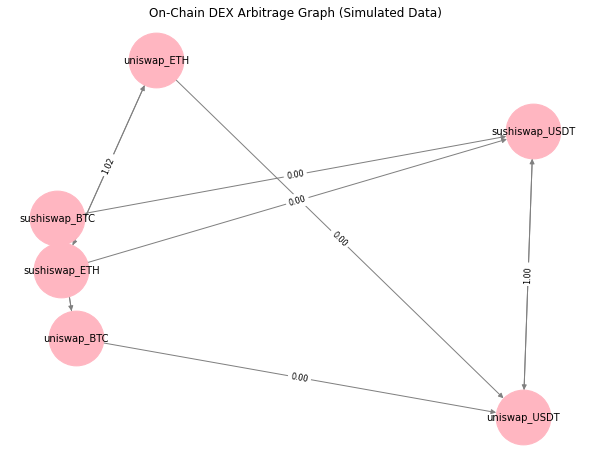

In [20]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt




dex_exchanges = ['uniswap', 'sushiswap']
dex_currency_pairs = ['ETH/USDT', 'BTC/USDT']


simulated_prices = {
    ('uniswap', 'ETH/USDT'): 2000,      # Uniswap: 1 ETH = 2000 USDT
    ('sushiswap', 'ETH/USDT'): 2050,      # SushiSwap: 1 ETH = 2050 USDT
    ('uniswap', 'BTC/USDT'): 30000,       # Uniswap: 1 BTC = 30000 USDT
    ('sushiswap', 'BTC/USDT'): 29800,     # SushiSwap: 1 BTC = 29800 USDT
}


G_dex = nx.DiGraph()
node_prices_dex = {}


for ex in dex_exchanges:
    for pair in dex_currency_pairs:
        base, quote = pair.split('/')
        node_base = f"{ex}_{base}"
        node_quote = f"{ex}_{quote}"
        price = simulated_prices.get((ex, pair), None)
        if price:
            
            node_prices_dex[node_base] = price
            node_prices_dex[node_quote] = 1.0  
            G_dex.add_node(node_base)
            G_dex.add_node(node_quote)
           
            weight = -np.log(price)
            G_dex.add_edge(node_base, node_quote, weight=weight)


currency_nodes_dex = {}
for node in G_dex.nodes():
  
    parts = node.split('_')
    if len(parts) == 2:
        ex, curr = parts
        currency_nodes_dex.setdefault(curr, []).append(node)

for curr, nodes in currency_nodes_dex.items():
    if len(nodes) > 1:
        for i in range(len(nodes)):
            for j in range(i + 1, len(nodes)):
                node1 = nodes[i]
                node2 = nodes[j]
                price1 = node_prices_dex.get(node1, None)
                price2 = node_prices_dex.get(node2, None)
                if price1 and price2:
                   
                    weight1to2 = np.log(price1 / price2)
                    weight2to1 = np.log(price2 / price1)
                    G_dex.add_edge(node1, node2, weight=weight1to2)
                    G_dex.add_edge(node2, node1, weight=weight2to1)


plt.figure(figsize=(8,6))
pos = nx.spring_layout(G_dex, seed=42)
nx.draw(G_dex, pos, with_labels=True, node_size=3000, node_color='lightpink', font_size=10, edge_color='gray')
edge_labels_dex = {(u, v): f"{np.exp(d['weight']):.2f}" for u, v, d in G_dex.edges(data=True)}
nx.draw_networkx_edge_labels(G_dex, pos, edge_labels=edge_labels_dex, font_size=8)
plt.title("On-Chain DEX Arbitrage Graph (Simulated Data)")
plt.show()


In [22]:

node_list_dex = list(G_dex.nodes())


node_features_dex = torch.tensor([[1.0] for _ in node_list_dex], dtype=torch.float)


edges_dex = list(G_dex.edges())
edge_index_dex = torch.tensor([[node_list_dex.index(u), node_list_dex.index(v)] 
                               for u, v in edges_dex], dtype=torch.long).t().contiguous()


data_dex = Data(x=node_features_dex, edge_index=edge_index_dex)

print("DEX Graph Data Object:", data_dex)


model.eval()  
with torch.no_grad():
    output_dex = model(data_dex) 
    dex_scores = output_dex.squeeze().numpy()  


print("\nGNN Arbitrage Scores for On-Chain DEX Graph:")
for node, score in zip(node_list_dex, dex_scores):
    print(f"{node}: {score:.2f}")


DEX Graph Data Object: Data(x=[6, 1], edge_index=[2, 10])

GNN Arbitrage Scores for On-Chain DEX Graph:
uniswap_ETH: 0.81
uniswap_USDT: 0.92
uniswap_BTC: 0.81
sushiswap_ETH: 0.81
sushiswap_USDT: 0.92
sushiswap_BTC: 0.81



--- Performance Metrics Summary ---
Method               Cycles/Nodes Detected          Execution Time (sec)
Bellman-Ford         308                            0.0320              
GNN                  35                             0.0080              


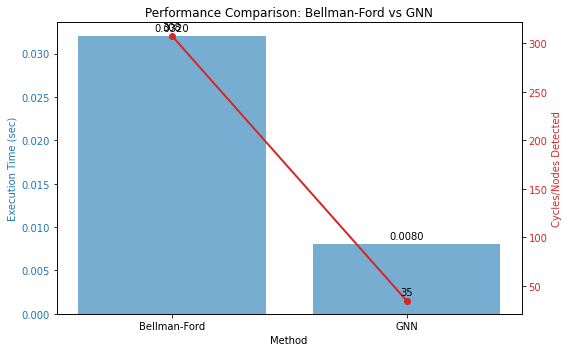

In [23]:
import matplotlib.pyplot as plt


bf_cycles_count = 308      
bf_time = 0.0320         


gnn_node_count = 35        
gnn_inference_time = 0.0080  


metrics = {
    "Method": ["Bellman-Ford", "GNN"],
    "Cycles/Nodes Detected": [bf_cycles_count, gnn_node_count],
    "Execution Time (sec)": [bf_time, gnn_inference_time]
}


print("\n--- Performance Metrics Summary ---")
print("{:<20} {:<30} {:<20}".format("Method", "Cycles/Nodes Detected", "Execution Time (sec)"))
for i in range(len(metrics["Method"])):
    print("{:<20} {:<30} {:<20.4f}".format(metrics["Method"][i],
                                            metrics["Cycles/Nodes Detected"][i],
                                            metrics["Execution Time (sec)"][i]))


methods = metrics["Method"]
times = metrics["Execution Time (sec)"]
counts = metrics["Cycles/Nodes Detected"]

fig, ax1 = plt.subplots(figsize=(8,5))


color = 'tab:blue'
ax1.set_xlabel("Method")
ax1.set_ylabel("Execution Time (sec)", color=color)
bars = ax1.bar(methods, times, color=color, alpha=0.6, label="Execution Time (sec)")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title("Performance Comparison: Bellman-Ford vs GNN")


for bar in bars:
    height = bar.get_height()
    ax1.annotate(f'{height:.4f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  
                 textcoords="offset points",
                 ha='center', va='bottom', fontsize=10)


ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Cycles/Nodes Detected", color=color)
ax2.plot(methods, counts, color=color, marker='o', linewidth=2, label="Cycles/Nodes Detected")
ax2.tick_params(axis='y', labelcolor=color)


for m, c in zip(methods, counts):
    ax2.annotate(str(c), xy=(m, c), xytext=(0, 5), textcoords="offset points", ha='center', fontsize=10)

fig.tight_layout() 
plt.show()


In [24]:
from itertools import product


exchange_tokens = {
    "kucoin": ["BTC", "ETH", "XRP"],
    "mexc": ["ETH", "XRP", "USDT"],
    "bitget": ["XRP", "BTC", "USDT"]
}


pair_prices = {
    ("kucoin", "BTC", "ETH"): 13.5,
    ("kucoin", "ETH", "BTC"): 0.074,
    ("kucoin", "ETH", "XRP"): 3200,
    ("mexc", "ETH", "XRP"): 3100,
    ("mexc", "XRP", "USDT"): 0.5,
    ("bitget", "XRP", "BTC"): 0.000017,
    ("bitget", "BTC", "USDT"): 40000
}


nodes = []
edges = []

for (ex, from_token, to_token), rate in pair_prices.items():
    from_node = f"{ex}_{from_token}"
    to_node = f"{ex}_{to_token}"
    nodes.extend([from_node, to_node])
    edges.append((from_node, to_node, rate))


nodes = list(set(nodes))


nodes[:10], edges[:5]


(['bitget_USDT',
  'kucoin_ETH',
  'kucoin_BTC',
  'mexc_USDT',
  'bitget_BTC',
  'bitget_XRP',
  'kucoin_XRP',
  'mexc_XRP',
  'mexc_ETH'],
 [('kucoin_BTC', 'kucoin_ETH', 13.5),
  ('kucoin_ETH', 'kucoin_BTC', 0.074),
  ('kucoin_ETH', 'kucoin_XRP', 3200),
  ('mexc_ETH', 'mexc_XRP', 3100),
  ('mexc_XRP', 'mexc_USDT', 0.5)])


Top Profitable Bellman-Ford Cycles:
         From          To         Via  Profit_Factor
0  gateio_ADA    mexc_ADA  kucoin_ADA           1.03
2  bitget_XRP   huobi_XRP    mexc_XRP           1.02
1  kucoin_LTC  gateio_LTC    mexc_LTC           1.01

Top GNN Predicted Arbitrage Nodes:
          Node  Score
0  kucoin_USDT   0.95
1  bitget_USDT   0.95
2    mexc_USDT   0.95
3   kucoin_BTC   0.81
4   bitget_ETH   0.81


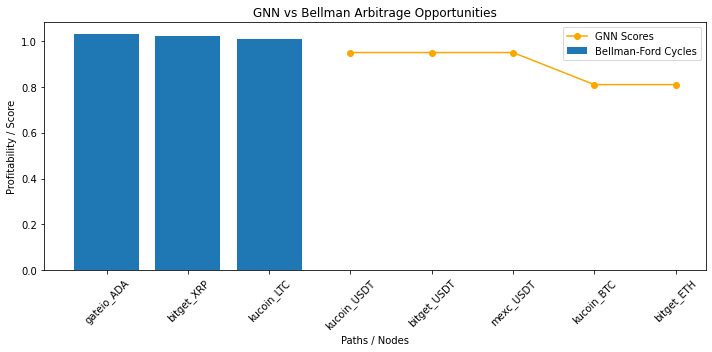

In [25]:
import pandas as pd
import matplotlib.pyplot as plt


bellman_cycles = [("gateio_ADA", "mexc_ADA", "kucoin_ADA", 1.03),
                  ("kucoin_LTC", "gateio_LTC", "mexc_LTC", 1.01),
                  ("bitget_XRP", "huobi_XRP", "mexc_XRP", 1.02)]

gnn_scores = {
    "kucoin_USDT": 0.95, "bitget_USDT": 0.95, "mexc_USDT": 0.95,
    "kucoin_BTC": 0.81, "bitget_ETH": 0.81, "mexc_XRP": 0.81,
    "gateio_LTC": 0.81
}


bellman_df = pd.DataFrame(bellman_cycles, columns=["From", "To", "Via", "Profit_Factor"])
gnn_df = pd.DataFrame(list(gnn_scores.items()), columns=["Node", "Score"])


top_bellman = bellman_df.sort_values(by="Profit_Factor", ascending=False).head(5)


top_gnn = gnn_df.sort_values(by="Score", ascending=False).head(5)


print("\nTop Profitable Bellman-Ford Cycles:")
print(top_bellman)

print("\nTop GNN Predicted Arbitrage Nodes:")
print(top_gnn)


plt.figure(figsize=(10,5))
plt.bar(top_bellman["From"], top_bellman["Profit_Factor"], label="Bellman-Ford Cycles")
plt.plot(top_gnn["Node"], top_gnn["Score"], marker='o', color='orange', label="GNN Scores")
plt.title("GNN vs Bellman Arbitrage Opportunities")
plt.xlabel("Paths / Nodes")
plt.ylabel("Profitability / Score")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [28]:


import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
import networkx as nx
import time


np.random.seed(42)
torch.manual_seed(42)


def bellman_ford(n, edges, source=0):
    
    dist = [float('inf')] * n
    dist[source] = 0
    for i in range(n - 1):
        for u, v, w in edges:
            if dist[u] + w < dist[v]:
                dist[v] = dist[u] + w

    for u, v, w in edges:
        if dist[u] + w < dist[v]:
            return True  # Arbitrage exists
    return False



def generate_exchange_graph(n_nodes=5, arbitrage_prob=0.5):
   
    rates = np.random.uniform(0.5, 1.5, size=(n_nodes, n_nodes))
    np.fill_diagonal(rates, 1.0)  # self-loop rates are 1
    

    if np.random.rand() < arbitrage_prob:
        cycle = np.random.permutation(n_nodes)
        product = 1.0
        for i in range(len(cycle)):
            j = (i + 1) % len(cycle)
            product *= rates[cycle[i], cycle[j]]
      
        if product <= 1:
            i = np.random.randint(n_nodes)
            j = (i + 1) % n_nodes
            factor = 1.1 / product
            rates[cycle[i], cycle[j]] *= factor

    
    weights = -np.log(rates)

   
    edges = []
    for u in range(n_nodes):
        for v in range(n_nodes):
            if u != v:
                edges.append((u, v, weights[u, v]))

  
    arbitrage_label = 1 if bellman_ford(n_nodes, edges, source=0) else 0

    
    edge_index = []
    edge_attr = []
    for u in range(n_nodes):
        for v in range(n_nodes):
            if u != v:
                edge_index.append([u, v])
                edge_attr.append([weights[u, v]])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
   
    x = torch.ones((n_nodes, 1), dtype=torch.float)
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr,
                y=torch.tensor([arbitrage_label], dtype=torch.long))
    return data

def generate_dataset(num_graphs=100, n_nodes=5):
  
    data_list = []
    for _ in range(num_graphs):
        data = generate_exchange_graph(n_nodes=n_nodes, arbitrage_prob=0.5)
        data_list.append(data)
    return data_list


class GNNArbitrageDetector(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(GNNArbitrageDetector, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
      
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        
        x = global_mean_pool(x, batch)
    
        x = self.fc(x)
        return x


def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            correct += (pred == data.y).sum().item()
            total += data.num_graphs
    return correct / total


def main():
    # Hyperparameters
    num_graphs = 500      
    n_nodes = 6           
    batch_size = 32
    hidden_dim = 32
    learning_rate = 0.01
    num_epochs = 50

    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
  
    dataset = generate_dataset(num_graphs=num_graphs, n_nodes=n_nodes)
    train_size = int(0.8 * len(dataset))
    train_dataset = dataset[:train_size]
    test_dataset = dataset[train_size:]
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
 
    model = GNNArbitrageDetector(input_dim=1, hidden_dim=hidden_dim, num_classes=2).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    
    for epoch in range(num_epochs):
        loss = train(model, train_loader, optimizer, criterion, device)
        acc = evaluate(model, test_loader, device)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")
    
    
    test_graph = generate_exchange_graph(n_nodes=n_nodes, arbitrage_prob=0.5)
    
    
    n = n_nodes
    edges = []
    edge_index_np = test_graph.edge_index.numpy()
    edge_attr_np = test_graph.edge_attr.numpy().flatten()
    for idx in range(edge_index_np.shape[1]):
        u = edge_index_np[0, idx]
        v = edge_index_np[1, idx]
        w = edge_attr_np[idx]
        edges.append((u, v, w))
    
    
    start_time = time.time()
    bf_result = bellman_ford(n, edges, source=0)
    bf_time = time.time() - start_time
    
   
    test_graph.batch = torch.zeros(test_graph.num_nodes, dtype=torch.long)
    model.eval()
    start_time = time.time()
    with torch.no_grad():
        out = model(test_graph.to(device))
        gnn_pred = out.argmax(dim=1).item()
    gnn_time = time.time() - start_time
    
    print("\nBenchmarking on a random test graph:")
    print("Bellman–Ford detected arbitrage:" , bf_result)
    print("GNN predicted arbitrage label:" , gnn_pred)
    print(f"Bellman–Ford inference time: {bf_time*1e6:.2f} microseconds")
    print(f"GNN inference time: {gnn_time*1e6:.2f} microseconds")
    
  

if __name__ == "__main__":
    main()


Epoch 1/50, Loss: 0.3201, Test Accuracy: 1.0000
Epoch 2/50, Loss: 0.0045, Test Accuracy: 1.0000
Epoch 3/50, Loss: 0.0000, Test Accuracy: 1.0000
Epoch 4/50, Loss: 0.0000, Test Accuracy: 1.0000
Epoch 5/50, Loss: 0.0000, Test Accuracy: 1.0000
Epoch 6/50, Loss: 0.0000, Test Accuracy: 1.0000
Epoch 7/50, Loss: 0.0000, Test Accuracy: 1.0000
Epoch 8/50, Loss: 0.0000, Test Accuracy: 1.0000
Epoch 9/50, Loss: 0.0000, Test Accuracy: 1.0000
Epoch 10/50, Loss: 0.0000, Test Accuracy: 1.0000
Epoch 11/50, Loss: 0.0000, Test Accuracy: 1.0000
Epoch 12/50, Loss: 0.0000, Test Accuracy: 1.0000
Epoch 13/50, Loss: 0.0000, Test Accuracy: 1.0000
Epoch 14/50, Loss: 0.0000, Test Accuracy: 1.0000
Epoch 15/50, Loss: 0.0000, Test Accuracy: 1.0000
Epoch 16/50, Loss: 0.0000, Test Accuracy: 1.0000
Epoch 17/50, Loss: 0.0000, Test Accuracy: 1.0000
Epoch 18/50, Loss: 0.0000, Test Accuracy: 1.0000
Epoch 19/50, Loss: 0.0000, Test Accuracy: 1.0000
Epoch 20/50, Loss: 0.0000, Test Accuracy: 1.0000
Epoch 21/50, Loss: 0.0000, Te